In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import jcl
from scipy.signal import savgol_filter
from functools import cached_property
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cosine
import pickle

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
def compute_bins(position_range, bin_len=480):
    """ Compute bin edges for given spike times.

        Args:
            position_range - tuple or list with first position timestamp and last position time stamp
            bin_len - length of a bin in ms (default 1s/50 = 20ms which is 480 samples of spikes)
            sampling_period - sampling period in ms (default 1s/20kHz = 0.05ms)
        Return:
            List of bin edges (in ms), total number of bins
    """
    
    bin_num = np.ceil( (position_range[-1] - position_range[0]) / bin_len).astype(int)
    bin_edges = np.arange(position_range[0], position_range[-1]+bin_len, bin_len)
    
    return bin_edges, bin_num

def bins_from_spike_times(spike_times, position_range, bin_len=480, dtype=np.uint16, dense_loading=True, return_mat_type=np.array):
    """ Bin given spike times, each bin contains total number of spikes.

        Args:
            spike_times - list of spike times per neuron (list of iterables, pre-sorted in a non-descending order)
            position_range - tuple or list with first position timestamp and last position time stamp
            bin_len - length of a bin in ms (default 1s/50 = 20ms)
            sampling_period - sampling period in ms (default 1s/24kHz)  1/480
            dtype - dtype to use for bins, default np.uint16 (np.uint8 would use less memory, but can store only up to 256 spikes per bin)
            dense_loading - if True (default) load data into a dense np.ndarray then convert to a `return_mat_type` (fast), if False load into a sparse matrix (slow, but memory efficient)
            return_mat_type - type of matrix to be returned (default is sparse `csc_matrix` for efficient storage and relatively fast column slicing)
        Return:
            Matrix with spike count per bin ((neuron num, time bins), `return_mat_type`)
    """
    # leave this two lines here in case we find non-sorted spikes (.res files)
    # maxes = [np.max(st) if len(st) > 0 else 0 for st in spike_times]
    # last_spike_time = to_ms(np.max(maxes), sampling_period)  # in ms
    bin_edges, bin_num = compute_bins(position_range, bin_len)

    if dense_loading:
        # fastest loading (due to indexing), but requires a lot of memory
        binned_data = np.empty((len(spike_times), bin_num), dtype=np.uint16)
    else:
        # lil_matrix is fast for loading rows, convert later to return_mat_type
        binned_data = lil_matrix((len(spike_times), bin_num), dtype=np.uint16)
    print((bin_edges.shape), binned_data.shape)
    for n, st in enumerate(spike_times):
        hist = np.histogram(st, bins=bin_edges)[0]
        binned_data[n] = hist

    return return_mat_type(binned_data), bin_edges, bin_num

def speed_filter(positions, bin_len, speed_thr, speed_violation = 90):
    """ Filter positions based on speed.
        Return both parts where speed > speed_thr and where speed <= speed_thr.

            positions - array of positions of shape (n,1) or (n,2)
            bin_len - duration of temporal bins in ms
            speed_thr - threshold for speed
            speed_violation - speed in cm/s that is max achievable by rat
        Return:
            positions speed filtered with low speed set to 0, low speed position indices
    """
    assert speed_thr is not None
    window_size = 50
    poly_degree = 1
    # Apply the Savitzky-Golay filter
    smooth_pos = position.copy()
    smooth_pos[:,0] = savgol_filter(position[:,0], window_size, poly_degree)
    smooth_pos[:,1] = savgol_filter(position[:,1], window_size, poly_degree)
    
    speed = np.array( jcl.utils.calc_speed(smooth_pos,bin_len) )
    
    speed_violation_index = np.where(speed > speed_violation)[0]
    for i in speed_violation_index:
        speed[i]= np.mean(speed[i-10:i])
        
    # Window size and polynomial degree for the Savitzky-Golay filter
    window_size = 50
    poly_degree = 1
    # Apply the Savitzky-Golay filter
    smooth_speed = savgol_filter(speed, window_size, poly_degree)
    speed_l_idx = smooth_speed < speed_thr
    
    speed_filtered_positions = smooth_pos.copy()
    speed_filtered_positions[speed_l_idx] = [0,0]
    return speed_filtered_positions, speed_l_idx, smooth_speed,speed, smooth_pos

class Map:
    
    def __init__(self, mmap):
        self.__map = mmap
        self.__map_prob = None

    @property
    def map(self):
        """ Return the underlying map. """
        return self.__map

    @property
    def map_prob(self):
        """ Return the underlying map normalized to sum of 1. """
        if self.__map_prob is None:
            self.__map_prob = self.__map / self.__map.sum()
        return self.__map_prob

    # a map is an array
    # so we implement methods that are
    # absolutely essential for an array
    def __getitem__(self, idx):
        return self.__map.__getitem__(idx)

    @property
    def ndim(self):
        return self.__map.ndim

    @property
    def shape(self):
        return self.__map.shape

    @property
    def size(self):
        return self.__map.size


class OccupancyMap(Map):
    def __init__(self, positions, maze_size, bin_size, bin_len, smooth_sd=None):
        """ Produce occupancy map.

            Args:
                positions - array of positions of shape (n,1) or (n,2)
                maze_size - size of the maze in the same units as positions
                bin_size - size of spatial bins in the same units as positions
                bin_len - duration of temporal bins in ms
                smooth_sd - SD in bins for gaussian smoothing
            Return:
                occupancy - time in seconds spent in each spatial bin
        """
        self.binner = Binning(bin_size, maze_size)
        super().__init__(self.__compute_occ(positions, self.binner, bin_len, smooth_sd))
        self.bin_size = bin_size

    @staticmethod
    def __compute_occ(positions, binner, bin_len, smooth_sd=None):
        occupancy = np.zeros(binner.num_bins, dtype= np.int64)

        for p in positions:
            
            bin_idx = binner.bin_idx(p)
            if (abs(bin_idx[0]-bin_idx[1])!=40) and (abs(bin_idx[0]-bin_idx[1])!=0):
                occupancy[bin_idx] += bin_len
#         np.savetxt("./occup.csv",occupancy, fmt='%d',delimiter=",")
        if smooth_sd is not None:
            occupancy = gaussian_filter(occupancy, smooth_sd)
#         np.savetxt("./occup_smooth.csv",occupancy, fmt='%d',delimiter=",")

        return occupancy / 1000  # ms to seconds


class FiringRateMap(Map):
    def __init__(self, spike_train, positions, maze_size, bin_size, bin_len, smooth_sd=3):
        """ Produce firing rate map for the given single cell spike train.

            Args:
                positions - array of positions of shape (n,1) or (n,2)
                maze_size - size of the maze in the same units as positions
                bin_size - size of spatial bins in the same units as positions
                bin_len - duration of temporal bins in ms
                smooth_sd - SD in bins for gaussian smoothing
            """
        __fr_map, __occupancy = self.__compute_frm(spike_train, positions, maze_size, bin_size, bin_len, smooth_sd)
        super().__init__(__fr_map)
        self.__occupancy = __occupancy
        self.bin_size = bin_size
        self.__eps = 1e-15
        self.__I_sec = None
        self.__I_spike = None
        self.__sparsity = None
        self.__frs = None # mean, median, max

    @property
    def occupancy(self):
        """ Occupancy map. """
        return self.__occupancy
    
    @property
    def mean_fr(self):
        """ Mean firing rate in Hz. """
        if self.__frs is None:
            self.__frs = self.__compute_frs()
        return self.__frs[0]
    
    def __compute_frs(self):
        """ Compute mean, median and max firing rates from given firing rate map.
            Ignore nans, infs and values smaller than eps.

            Return:
                (mean, median, max) FR in Hz
        """
        not_nan = np.logical_not(np.isnan(self.map))
        not_inf = np.logical_not(np.isinf(self.map))
        good = np.logical_and(not_nan, not_inf)
        good = np.logical_and(good, self.map >= self.__eps)
        frm = self.map[good]
        if frm.size == 0:
            return 0, 0, 0
        return frm.mean(), np.median(frm), frm.max()

    @staticmethod
    def __compute_frm(spike_train, positions, maze_size, bin_size, bin_len, smooth_sd):
        """ Produce firing rate map for the given single cell spike train.

            Args:
                positions - array of positions of shape (n,1) or (n,2)
                maze_size - size of the maze in the same units as positions
                bin_size - size of spatial bins in the same units as positions
                bin_len - duration of temporal bins in ms
                smooth_sd - SD in bins for gaussian smoothing
                return_occupancy - whether to return occupancy map
            Return:
                firing rate map - matrix with firing rate (Hz) in each spatial bin
        """
        assert len(spike_train) == len(positions)
        occupancy = OccupancyMap(positions, maze_size, bin_size, bin_len, smooth_sd)
        frm = np.zeros_like(occupancy.map)

        for p, sn in zip(positions, spike_train):
            bin_idx = occupancy.binner.bin_idx(p)
            frm[bin_idx] += sn

        frm = frm / occupancy.map
        frm[np.isnan(frm)] = 0
        frm[np.isinf(frm)] = 0
        frm = gaussian_filter(frm, smooth_sd)
        return frm, occupancy

class Binning:
    def __init__(self, bin_size, maze_size):
        self.bin_size = bin_size
        self.maze_size = maze_size
        
    def bin_idx(self, p):
        """ Calculate bin index for given position.

            Args:
                p - position
                bin_size - size of bins, single number or same shape as `p`
                maze_size - size of the maze (number of bins per dimension)
            Return:
                bin index - tuple of the same shape as `p`
        """
        idx = tuple((p // self.bin_size).astype(int))
        # origin to lower left corner
        return (self.num_bins[1] - idx[1] - 1, idx[0])

    @cached_property
    def num_bins(self):
        """ Calculate number of spatial bins (per dimension). """
        return 1 + (np.array(self.maze_size) / self.bin_size).astype(int)
    
def plot_map(m: Map, title=None, colorbar_label=None, path=None):
    """ Plot given with added color bar."

        Args:
            m - map
            title - figure title
            colorbar_label - label to be used for the colorbar
            path - file path to which to save the figure, if none show the figure
    """
    if m.ndim == 1:
        im = np.expand_dims(m.map, 1)
        im = np.repeat(im.map, 3, 1).T
    else:
        im = m.map
        
    # Create a figure and axis
    fig, ax = plt.subplots()

    plt.set_cmap("jet")
    plt.imshow(im)

    # Add the label text in black
    ax.text(33, 13, "Start", fontsize=12, color='white', ha='center', va='center')
    ax.text(14, 5, "Chocolate", fontsize=12, color='white', ha='center', va='center')
    ax.text(38, 25, "Honey", fontsize=12, color='white', ha='center', va='center')

    cb = plt.colorbar(ticks=[0., np.max(im)])
    if colorbar_label is not None:
        cb.set_ticklabels([0, np.round(np.max(im))])
        cb.set_label("Hz", fontsize=18)

    if title is not None:
        plt.title(title)

    if path is not None:
        plt.savefig(path)
    else:
        plt.show()
    plt.close()    

(582383,) (63, 582382)


/tmp/ipykernel_5907/2976228813.py:227: RuntimeWarning: invalid value encountered in divide
  frm = frm / occupancy.map


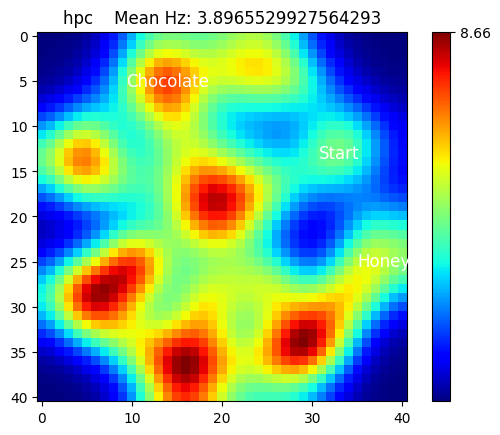

KeyboardInterrupt: 

In [8]:
path = "./"

session_shifts_path = path + 'session_shifts.txt' 
session_shifts = np.array(np.loadtxt(session_shifts_path), dtype=int)

day = "20220910"

whl_path = path + day

pos = pd.read_csv(   
                    whl_path +'.whl',
                    sep=" ",
                    header=None,
                    names=["x1","y1","x2","y2","timestamps","valid"]
)


pos["x1"],pos["y1"] = jcl.utils.interpolate_position(pos["x1"], pos["y1"], unknown_val=1023)
filtered_pos = pos[( pos['timestamps'] > 86400147) & (pos['timestamps'] <= 365943882 )].copy().reset_index()
filtered_pos.loc[(filtered_pos['timestamps'] > 231570138) & (filtered_pos['timestamps'] <= 294284235), ['x1', 'y1']] = 0

for brain_region in ["hpc","pfc"]:
    clu_path = path + day + '_merged_' + brain_region + '.clu'
    res_path = path + day + '_merged_' + brain_region + '.res'

    spike_times = jcl.load.spike_times_from_res_and_clu(res_path, clu_path, exclude_clusters=[0, 1], ts_limits=(filtered_pos.at[0,'timestamps'], filtered_pos.at[len(filtered_pos)-1,'timestamps']))

    for i in range(len(spike_times)):
        subarray = np.array(spike_times[i] , dtype = np.int64)
        spike_times[i] = subarray[ (subarray < 231570138 ) | (subarray >= 294284235 ) ].tolist()

    binned_data, bin_edges, bin_num = bins_from_spike_times( 
                                spike_times, 
                                (filtered_pos.at[0,'timestamps'], filtered_pos.at[len(filtered_pos)-1,'timestamps'])   
    )

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    #####CAN USE BIN EDGES INSTEAD OF BIN CENTERS IN THIS AND THEN YOU NEED TO SKIP THE LAST POSITION I THINK

    x1 = np.interp(bin_centers, filtered_pos['timestamps'], filtered_pos['x1'])
    y1 = np.interp(bin_centers, filtered_pos['timestamps'], filtered_pos['y1'])

    position = np.column_stack((x1, y1))
    speed_filtered_positions, low_speed_index, smooth_speed, raw_speed, smooth_pos = speed_filter(position, 20, 5)

    class ClusterPopulation():
        """
        A population of neurons from a given recording day. Each neuron is a ClusterUnit object.

        Assumptions: It assumes that cluster 0 contains artifacts and cluster 1 contains the noise in the clu file.
                     Trial files are assumed to start at 01 with sleep and first trial is file 02. This is important in functions that use session_shifts.
                     All spatial calculations assume a linear maze. Maze length and spatial bin size can be changed when generating ratemaps.
                     For 2D ratemaps, check func_basics.
                     Recording rates in Hz (for res, whl and session_shifts) are optional variables that might need to be changed.
                     These assumptions are also valid for the ClusterUnit class.

        Saving/Loading: to export the object use pickle.dump and to load, pickle.load
        """

        def __init__(self,binned_data):

            self.nclusters = binned_data.shape[0]
            self.unit = np.array( [None]*self.nclusters )
            self.mean_fr = np.zeros( [binned_data.shape[0], 1] )

    place_fields = ClusterPopulation(binned_data)
    
    
    for i in range((binned_data).shape[0]):    

        binned_data[i, :][low_speed_index] = 0 ## dont want to include spikes that happened when the animal was not moving

        bin_sizes = [3.2, 4, 5]
        smoothing = [2,2.5, 3]

        placemap = FiringRateMap(
                                                binned_data[i, :],
                                                speed_filtered_positions, 
                                                np.array([160,160]), ### MAYBE INCREASE TO 180
                                                np.array([4,4]), 
                                                20
                                                ,smooth_sd= 3
        )
        
        place_fields.unit[i] = placemap.map
        place_fields.mean_fr[i] = placemap.mean_fr
        plot_map(placemap, title = brain_region +"    Mean Hz: " + str(placemap.mean_fr))
                                                                     
    pickle.dump( place_fields, open( day +"_"+ brain_region +"_place_fields" , "wb" ) )
    
plot_map(placemap.occupancy, title = "Occupancy Map")

In [9]:
place_field = pickle.load( open( day + "_" + brain_region + "_place_fields"   , 'rb'  ))

print(place_field.unit)

# spike_id = func_basics.read_integers(spike_id_filename)
# spike_time = func_basics.read_integers(spike_time_filename)

good_cell = range(len(place_field.unit.shape[0]))

####      Time ranges to decode 
#         86400147 - 231570138
#         294284235 - 365943882

##for now all spike times :then use speed filtered spike times
# event_spike_times = spike_time[( 86400147  <= spike_time  ) 
#                                & ( spike_time <= 231570138 )  
#                                & (  spike_id > 1  )]

# event_spike_id = spike_id[( 86400147  <= spike_time  ) 
#                                & ( spike_time <= 231570138 )  
#                                & (  spike_id > 1  )]
# speed_filter = 5

## use the spike time ranges to only select those spike bins and position bins where the corresponding bin edge is less than the end of the range
## ensure you return the speed array and then do same filtering for the speed array - then get the low speed index and replace all together

## just get the time from the bin edges and bin centers

## bins is position bin width and bin_width is time bin width
position_bins = np.array(list(range(bins//2, 360+(bins//2), bins)))
## simply get the matrix that is found in place map calculation of positon 160,160 divided by bin size over the length of the bin size 

position_probability, estimated_position_time,estimated_position_interp, estimated_position = calculate_estimated_position(t,t0,bin_width,place_field.unit,  
                                                                                                 event_spike_times_speed_filtered,
                                                                                                 event_spike_id_speed_filtered, 
                                                                                                 position_bins, good_cell)

## pass bin centers, binned_spikes after speed filtering, position bin matrix. list of good cells, bin width

[array([[0.00812231, 0.01482468, 0.03181846, ..., 0.01631147, 0.00779419,
         0.00455628],
        [0.01332543, 0.02235149, 0.04437442, ..., 0.02486179, 0.01305694,
         0.00836847],
        [0.02623799, 0.04027947, 0.07285707, ..., 0.04502657, 0.02612679,
         0.01820184],
        ...,
        [0.06426821, 0.08548782, 0.12959891, ..., 0.11217801, 0.05132993,
         0.0272413 ],
        [0.02707419, 0.0375033 , 0.06016076, ..., 0.07105862, 0.03101493,
         0.01552932],
        [0.0129723 , 0.01890957, 0.0324183 , ..., 0.05154235, 0.02181127,
         0.01049868]])
 array([[0.01499782, 0.02455774, 0.04694533, ..., 0.00976816, 0.00502949,
         0.00311056],
        [0.02307208, 0.03610167, 0.0656738 , ..., 0.01485347, 0.00829845,
         0.00554143],
        [0.04137791, 0.06168852, 0.10609767, ..., 0.02680385, 0.01635823,
         0.0117492 ],
        ...,
        [0.01590098, 0.0212286 , 0.03252203, ..., 0.03213428, 0.01419433,
         0.0073681 ],
        [0.00

TypeError: object of type 'int' has no len()

In [10]:
bins = 4
np.array(list(range(bins//2, 160+(bins//2), bins)))

array([  2,   6,  10,  14,  18,  22,  26,  30,  34,  38,  42,  46,  50,
        54,  58,  62,  66,  70,  74,  78,  82,  86,  90,  94,  98, 102,
       106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 154,
       158])

In [120]:

# Example array of 3 matrices
matrix1 = np.array([[3, 1, 4],
                   [2, 8, 5],
                   [7, 6, 9]])

matrix2 = np.array([[10, 11, 12],
                   [13, 14, 15],
                   [16, 17, 18]])

matrix3 = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

array_of_matrices = [matrix1, matrix2, matrix3]

# Calculate argmax for all matrices along both axes (rows and columns)
argmax_array = np.argmax(np.stack(array_of_matrices), axis=2)
argmax_array = np.argmax(argmax_array, axis=1)

# Display the array of argmax values
print(argmax_array)


[0 0 0]


In [124]:
# Example array of matrices (you can replace this with your own data)
array_of_matrices = [np.array(
    
                             [[31, 1, 4],
                               [2, 8, 5],
                               [7, 6, 9]]
),np.array(
                              [[10, 11, 12],
                               [13, 14, 15],
                               [16, 17, 18]]
),np.array(
                              [[10, 11, 12],
                               [13, 14, 15],
                               [16, 170, 18]])
                    ]

# Use list comprehension to calculate argmax for each matrix
argmax_array = np.array([ np.unravel_index(np.argmax(matrix, axis=None), matrix.shape) for matrix in array_of_matrices])

# Display the array of argmax values
print(argmax_array)
print(    np.max(array_of_matrices, axis = (1,2))    )

[[0 0]
 [2 2]
 [2 1]]
[ 31  18 170]


In [51]:
def calculate_estimated_position(t, t0, time_bin_width, place_fields, spike_times, spike_id, position_bins, good_place_cells):
#def calculate_estimated_position(t0, time_bin_width, place_field, spike_times, spike_id, position_bins, good_place_cells):
    
    bayesian_threshold= 10 ** (np.log2(len(place_field)) - np.log2(800))
    place_fields = [np.where(place_cell < bayesian_threshold, bayesian_threshold, place_cell) for place_cell in place_fields]

    position_probability = np.zeros((len(position_bins), len(t0))) ## make this a stack of matrices
    
    for j in range( binned_spikes.shape[0] ):
        position_probability[:, j] = reconstruct( j, time_bin_width, place_field, binned_spikes[:,j] , position_bins, good_place_cells).T 
        ## replace the index of the matrix in the stack
        
    probability = np.max( position_probability, axis = (1,2) )
    position_index = np.array([ np.unravel_index( np.argmax(matrix, axis=None), matrix.shape ) for matrix in position_probability] )
    
    estimated_position = np.array(position_bins[position_index] )## make this 2d too 
    index = np.where(probability > 0.2)[0]
    #print(probability)
    #print(position_index)
    #print(index)
    #estimated_position_time = t0 + bin_width / 2
    estimated_position_time = t0
#     estimated_position_interp = interp1d(estimated_position_time[index]/20000, estimated_position[index], kind='linear',fill_value="extrapolate")(t)
#     return position, estimated_position_time, estimated_position_interp, estimated_position

    return position_probability, estimated_position_time, estimated_position

def reconstruct(j, bin_width, place_field, binned_spikes, position_bins, good_place_cells):
    
    bayesian_threshold= 10 ** (np.log2(len(place_field)) - np.log2(800))
    product_of_place_fields = np.ones(position_bins.shape) 
    sum_of_place_fields = np.zeros(position_bins.shape) 

    for k in good_place_cells:
        n = binned_spikes[k]
        single_place_field = place_field[k]
        product_of_place_fields *= np.power(single_place_field, n)
        product_of_place_fields[np.isinf(product_of_place_fields)] = 1e200 ## check how big the value is
        sum_of_place_fields += single_place_field
        
    position_probability = product_of_place_fields * np.exp(-bin_width * sum_of_place_fields) 
    position_probability /= np.sum(position_probability) ### so the probability over all 160x160 positions sums to one
                                           
    return position_probability
                                           
#         # Figure 1: Bayesian decoding
#         fig1 = plt.figure(figsize=(len(position_bins)/12, len(position_bins)/10), dpi=80)

#         # Plotting the estimated position matrix
#         plt.imshow(np.flipud(position_probability), extent=[min(estimated_position_time), max(estimated_position_time), 
#                                                                      min(position_bins)-(bins//2),max(position_bins)+(bins//2)], 
#                                                                      aspect='auto', cmap='bone')
#         plt.gca().invert_yaxis()
#         plt.colorbar()
#         # Plotting the estimated position line
#         #plt.plot(t, estimated_position_interp, 'r', linewidth=2)
#         plt.plot(t0, estimated_position, 'r', linewidth=2)
#         plt.title(category+" "+ str(trial_number))
#         plt.ylabel('Position')
#         plt.xlabel('Time(s)')

#         #actual position
#         #plt.plot(t, position, 'g', linewidth=2 ) ## plot the smoothened positions or the speed filtered position
                                        
#         plt.plot(t0, position_interp, 'g', linewidth=2 )

#         plt.show()

#         fig3 = plt.figure(figsize=(40, 8),dpi=40)
#         place_field_array = np.array(place_field)
#         selected = np.vstack([place_field_array[i, :] for i in event_spike_id_speed_filtered if neuron_class[i]=="p1"]).T
#         plt.imshow(selected, cmap='hot', aspect='auto')
#         plt.colorbar()
#         plt.title('Matrix Visualization')
#         plt.xlabel('Column Index')
#         plt.ylabel('Row Index')
#         plt.show()

(0.0, 160.0)

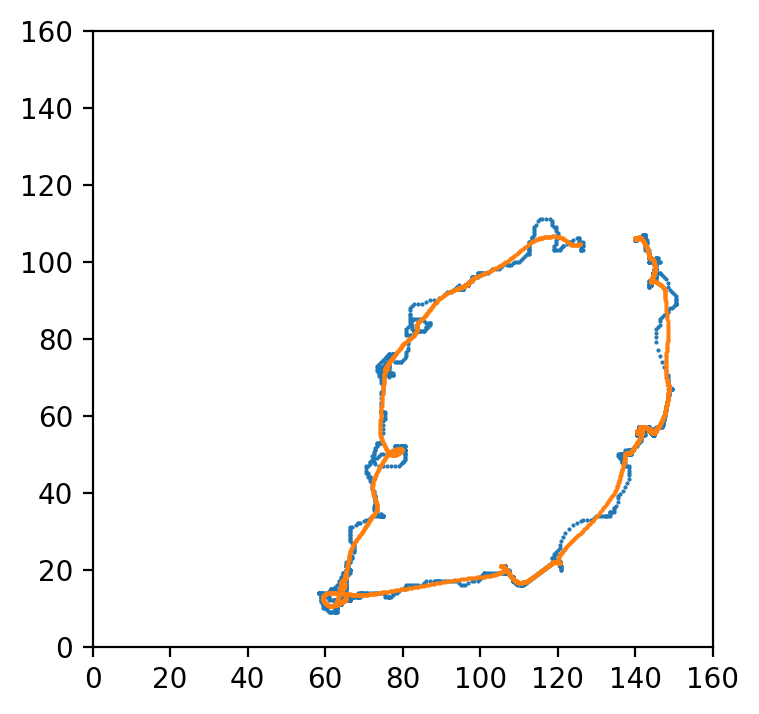

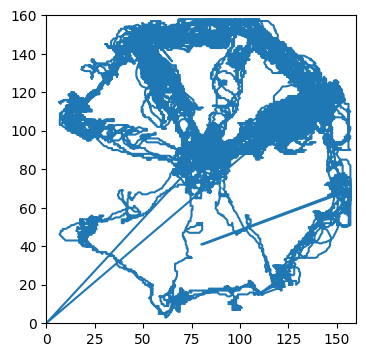

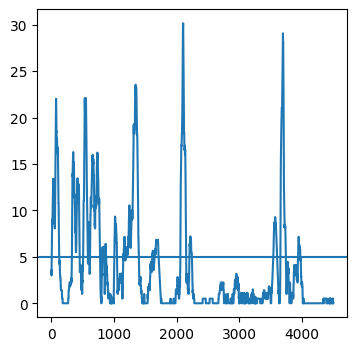

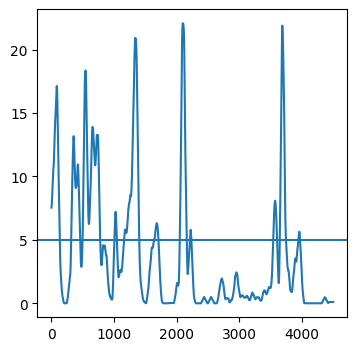

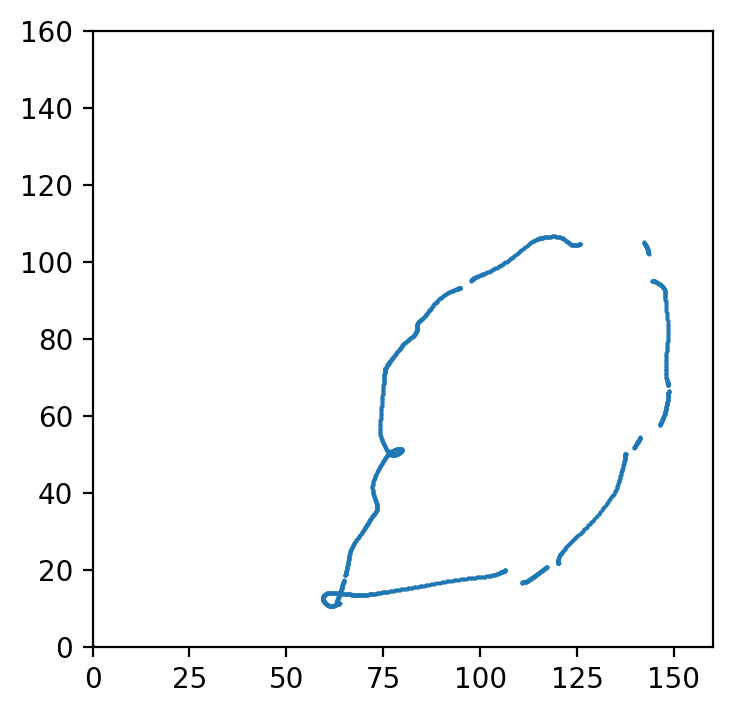

In [32]:




plt.figure(figsize=(4,4), dpi = 200)
plt.scatter(position[11500:16000,0],position[11500:16000,1],s=1,  marker='.')
plt.scatter(smooth_pos[11500:16000,0],smooth_pos[11500:16000,1],s=1,  marker='.')
plt.xlim([0,160])
plt.ylim([0,160])
plt.xticks([0,20,40,60,80,100,120,140,160])
plt.yticks([0,20,40,60,80,100,120,140,160])

plt.figure(figsize=(4,4))
plt.plot(position[:,0],position[:,1])
plt.xlim([0,160])
plt.ylim([0,160])

plt.figure(figsize=(4,4))
plt.plot(raw_speed[11500:16000])
plt.axhline(y=5)

plt.figure(figsize=(4,4))
plt.plot(smooth_speed[11500:16000])
plt.axhline(y=5)

plt.figure(figsize=(4,4), dpi = 200)
plt.scatter(speed_filtered_positions[11500:16000,0],speed_filtered_positions[11500:16000,1],s=1,  marker='.')
plt.xlim([0,160])
plt.ylim([0,160])

In [6]:
plot_map(placemap.occupancy, title= "occupancy")

plt.figure(figsize=(4,4))
plt.plot(position[:,0],position[:,1])
plt.xlim([0,160])
plt.ylim([0,160])

NameError: name 'placemap' is not defined

In [ ]:
# Window size and polynomial degree for the Savitzky-Golay filter
window_size = 10
poly_degree = 1

for window_size in [5, 10, 20, 25]:
    p=1
    for poly in range(1,5):
        smooth_speed = savgol_filter(speed, window_size, poly)

        plt.figure(figsize=(24,30), dpi = 500)
        plt.subplot(5,1,p)
        plt.plot(smooth_speed)
        plt.title("window "+ str(window_size)+" poly_degree: "+str(poly))
        p+=1
    plt.subplot(5,1,p)
    plt.plot(speed)
#     plt.ylim([0, 1200])
    plt.show()

In [ ]:
for i in range(1,2):    
    binned_data[i, :][low_speed_index] = 0 ## dont want to include spikes that happened when the animal was not moving
    
    bin_sizes = [3.2, 4]
    smoothing = [ 2,2.5,3]
    #################################### occupancy sd is 2.5
    for bin_size in bin_sizes:
        for sd in smoothing:
    
            placemap = FiringRateMap(
                                                    binned_data[i, :],
                                                    speed_filtered_positions, 
                                                    np.array([160,160]), 
                                                    np.array([bin_size,bin_size]), 
                                                    20,
                                                    smooth_sd = sd
            )
            jcl.visualization.plot_map(placemap, title = str(bin_size) +" bin size      smoothing: "+str(sd))
        jcl.visualization.plot_map(placemap.occupancy)


In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(position[11500:16000,0])
plt.plot(smooth_pos[11500:16000,0])
plt.ylim([0,160])
plt.yticks([0,20,40,60,80,100,120,140,160])
plt.subplot(1,2,2)
plt.plot(position[11500:16000,1])
plt.plot(smooth_pos[11500:16000,1])
plt.ylim([0,160])
plt.yticks([0,20,40,60,80,100,120,140,160])

plt.figure(figsize=(8,4))
plt.plot(smooth_speed[11500:16000])
plt.axhline(y=5)


In [ ]:
(np.where( (speed_filtered_positions[11500:16000,0] == 0) & (speed_filtered_positions[11500:16000,1] == 0))[0].size)/(16000-11500)

In [ ]:
(np.where( (position[11500:16000,0] == 0) & (position[11500:16000,1] == 0))[0].size)

In [ ]:
def calc_speed(positions, bin_len):
    """ Calculate animal speed. Units of positions / s.

        Args:
            positions - array of positions of shape (n,1) or (n,2)
            bin_len - duration of temporal bins in ms
        Return:
            speed - animal speed in each recorded point, same shape as positions
    """
    speed = []
    for i in range(1, len(positions)):
        prev_p = positions[i-1]
        current_p = positions[i]
        dist = np.linalg.norm(current_p-prev_p)
        speed.append(dist*1000 / bin_len )
    return [speed[0]] + speed

from scipy.signal import savgol_filter


speed= calc_speed(position, 20)
speed=np.array(speed)
speed_violation_index = np.where(speed>90)[0]
for i in speed_violation_index:
#     print(speed[i])
    speed[i]= np.mean(speed[i-10:i])
#     print(speed[i])
# Window size and polynomial degree for the Savitzky-Golay filter

window_size = 10
poly_degree = 2

# Apply the Savitzky-Golay filter
smooth_speed = savgol_filter(speed, window_size, poly_degree)

plt.figure(figsize=(24,12), dpi = 500)
plt.subplot(2,1,1)
plt.plot(smooth_speed)
plt.subplot(2,1,2)
plt.plot(speed)
# plt.ylim([0, 1200])
plt.show()

In [18]:
def speed_filter(positions, bin_len, speed_thr, speed_violation = 90):
    """ Filter positions based on speed.
        Return both parts where speed > speed_thr and where speed <= speed_thr.

            positions - array of positions of shape (n,1) or (n,2)
            bin_len - duration of temporal bins in ms
            speed_thr - threshold for speed
            speed_violation - speed in cm/s that is max achievable by rat
        Return:
            positions speed filtered with low speed set to 0, low speed position indices
    """
    assert speed_thr is not None
    speed = np.array(jcl.utils.calc_speed(positions, bin_len))
    
    speed_violation_index = np.where(speed > speed_violation)[0]
    for i in speed_violation_index:
        speed[i]= np.mean(speed[i-10:i])
        
    # Window size and polynomial degree for the Savitzky-Golay filter
    window_size = 10
    poly_degree = 2
    # Apply the Savitzky-Golay filter
    smooth_speed = savgol_filter(speed, window_size, poly_degree)
    
    speed_l_idx = smooth_speed < speed_thr
    
    speed_filtered_positions = positions.copy()
    speed_filtered_positions[speed_l_idx] = [0,0]
    return speed_filtered_positions, speed_l_idx

speed_filtered_positions, low_speed_index = speed_filter(position, 20, 5)